In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import tensorflow as tf
import time
import scipy

import collections, numpy

import data_loader as dl
import data_transformer as dt

from sklearn.cluster import KMeans
from keras.utils import to_categorical

# helper for setting up the bidirectional, multilayer lstm
def bidirectional_lstm(input_data, num_layers, rnn_size, keep_prob, lengths=None):
    output = input_data
    for layer in range(num_layers):
        with tf.variable_scope('encoder_{}'.format(layer),reuse=tf.AUTO_REUSE):

            cell_fw = tf.contrib.rnn.LSTMCell(rnn_size, initializer=tf.truncated_normal_initializer(-0.1, 0.1, seed=2))
            cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw, input_keep_prob = keep_prob)

            cell_bw = tf.contrib.rnn.LSTMCell(rnn_size, initializer=tf.truncated_normal_initializer(-0.1, 0.1, seed=2))
            cell_bw = tf.contrib.rnn.DropoutWrapper(cell_bw, input_keep_prob = keep_prob)

            outputs, states = tf.nn.bidirectional_dynamic_rnn(cell_fw, 
                                                              cell_bw, 
                                                              output,
                                                              dtype=tf.float32,
                                                              sequence_length=lengths)
            output = tf.concat(outputs,2)

    return output

C:\Users\Michal\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# change this path to match the path of where you have the
# training_50 and validation files
txt_data_path = '../casp7_txt/'

max_len = 500 # max len of the protein taken into account
n_angles = 2 # 3 if consider all angles or 2 if only phi and psi

The data_lim is important because so far the full 13000 proteins crashes my system with 16Gb of ram

Load training data

In [39]:
file_name = 'training_50'
data_lim = 6000
prim_train, evo_train, dih_train, mask_train = (dl.parse_primary_from_file(txt_data_path + file_name, data_lim), 
                                                dl.parse_evolutionary_from_file(txt_data_path + file_name, data_lim),
                                                dl.load_file('./'+file_name+'_dih.joblib'),
                                                dl.parse_mask_from_file(txt_data_path + file_name, data_lim))
dih_train = dih_train[:data_lim]
len(prim_train), prim_train[0].shape, len(evo_train), evo_train[0].shape, len(dih_train), dih_train[0].shape, len(mask_train), mask_train[0].shape

Loaded data and filtered line endings
Extracted primary data
Encoded primary sequences
Loaded data and filtered line endings
Extracted evolutionary data


100%|███████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 37745.77it/s]


Grouped 21's together
Loaded data and filtered line endings
Extracted mask data


(6000, (70, 20), 6000, (70, 21), 6000, (70, 3), 6000, (70,))

Load validation data

In [40]:
file_name = 'validation'
prim_valid, evo_valid, dih_valid, mask_valid = (dl.parse_primary_from_file(txt_data_path + file_name), 
                                                dl.parse_evolutionary_from_file(txt_data_path + file_name),
                                                dl.load_file('./'+ file_name + '_dih.joblib'),
                                                dl.parse_mask_from_file(txt_data_path + file_name))
len(prim_valid), prim_valid[0].shape, len(evo_valid), evo_valid[0].shape, len(dih_valid), dih_valid[0].shape, len(mask_valid), mask_valid[0].shape

Loaded data and filtered line endings
Extracted primary data
Encoded primary sequences
Loaded data and filtered line endings
Extracted evolutionary data


100%|█████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 21346.51it/s]


Grouped 21's together
Loaded data and filtered line endings
Extracted mask data


(224, (269, 20), 224, (269, 21), 224, (269, 3), 224, (269,))

Pad the data and limit protein length. Prepare the data for training

In [41]:
prim_, evo_, dih_, mask_ = dt.limit_length_and_pad(prim_train, evo_train, dih_train, mask_train, max_len)
x_train, y_train = np.concatenate([prim_, evo_], axis=2), dih_[:,:,:n_angles]
prim_v, evo_v, dih_v, mask_v = dt.limit_length_and_pad(prim_valid, evo_valid, dih_valid, mask_valid, max_len)
x_valid, y_valid = np.concatenate([prim_v, evo_v], axis=2), dih_v[:,:,:n_angles]

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

padded
(5704,) (70, 20)
padded
(5704,) (70, 21)
padded
(5704,) (70, 3)
padded
(5704,) (70, 1)
padded
(213,) (269, 20)
padded
(213,) (269, 21)
padded
(213,) (269, 3)
padded
(213,) (269, 1)


((5704, 500, 41), (5704, 500, 2), (213, 500, 41), (213, 500, 2))

In [42]:
def manual_clusters(n_clusters):
    # these manually selecteed clusters will be chosen from left to right
    # when n_clusters < man_clusters.shape[0]
    man_clusters = np.array([[-1.5, 0, 0], [-1.5, 2.5, 0], [1.5, 0.5, 0], [-2.2, -2.5, 0],
                          [-1.5, 0, np.pi], [-1.5, 0, -np.pi], [-1.5, 2.5, np.pi], [-1.5, 2.5, -np.pi],
                            [0,0,0],[0,0,0]])
    try:
        return {
            i+1: man_clusters[:i+1] for i in range(man_clusters.shape[0])
        }[n_clusters]
    except KeyError as e:
        print("Manual clusters only support max", man_clusters.shape[0])
        print(e)
        raise

def kmeans_clusters(angles, limit_data, filter_, n_clusters):
    """
        angles: [..., ..., 3]
        limit_data: int, how many protein to consider for clustering
        filter_: bool, deciding if clusters too close to each other should be merged
    """
    def dist2(p1, p2):
        return np.sum((p1-p2)**2)

    def fuse(points, min_dist):
        ret = []
        d2 = min_dist * min_dist
        n = len(points)
        taken = [False] * n
        for i in range(n):
            if not taken[i]:
                count = 1
                point = points[i]
                taken[i] = True
                for j in range(i+1, n):
                    if dist2(points[i], points[j]) < d2:
                        point += points[j]
                        count+=1
                        taken[j] = True
                point /= count
                ret.append(point)
        return np.array(ret)
    
    print("Fitting KMeans...")
    km = KMeans(n_clusters=n_clusters, random_state=0, verbose=0, max_iter=1000).fit(angles[:limit_data].reshape(-1,n_angles))
    print("Done")
    if filter_:
        return fuse(km.cluster_centers_, min_dist=np.abs(np.max(angles)) / 10.)
    else:
        return km.cluster_centers_

def get_cluster_centers(select_clusters_n, mode='manual'):
    return {
        'manual': lambda n_clusters: manual_clusters(n_clusters=n_clusters),
        'kmeans': lambda n_clusters: kmeans_clusters(angles=y_train, limit_data=200, filter_=True, n_clusters=n_clusters)
    }[mode](select_clusters_n)

select_clusters_n = 10
# initialize clusters - this might filter ones that are too close
clusters = get_cluster_centers(select_clusters_n = select_clusters_n, mode='kmeans')[:,:n_angles]
n_clusters_after_fuse = clusters.shape[0]

# add missing clusters to much the desired number
clusters = np.pad(clusters, ((0, select_clusters_n - n_clusters_after_fuse), (0,0)), mode='constant')
n_clusters = clusters.shape[0]

"n_clusters_after_fuse:", n_clusters_after_fuse, 'fused', select_clusters_n - n_clusters_after_fuse, 'padded to', clusters.shape

Fitting KMeans...
Done


('n_clusters_after_fuse:', 10, 'fused', 0, 'padded to', (10, 2))

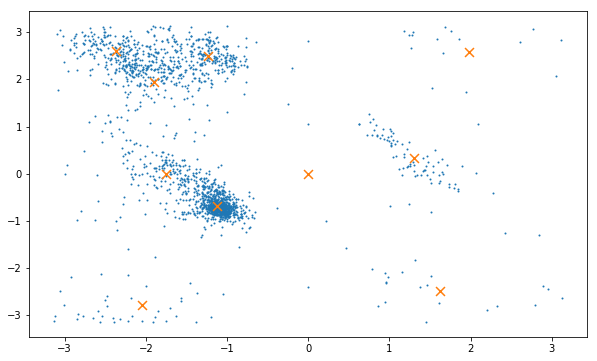

In [43]:
def plot_cluster_centers(data, clusters, x_i, y_i, data_lim=10):
    plt.figure(figsize=(10,6))
    plt.scatter(y_valid[:data_lim][:,:,x_i], y_valid[:data_lim][:,:,y_i], s=1)
    plt.scatter(clusters[:,x_i], clusters[:,y_i], marker='x', s=80)
    
plot_cluster_centers(y_valid, clusters, x_i=0, y_i=1, data_lim=10)
if n_angles == 3:
    plot_cluster_centers(y_valid, clusters, x_i=1, y_i=2, data_lim=10)
    plot_cluster_centers(y_valid, clusters, x_i=0, y_i=2, data_lim=10)

In [44]:
y_train_labels_ = np.argmin(scipy.spatial.distance_matrix(y_train.reshape(-1,n_angles), clusters), 
                            axis=1).reshape(y_train.shape[0], y_train.shape[1])

y_valid_labels_ = np.argmin(scipy.spatial.distance_matrix(y_valid.reshape(-1,n_angles), clusters), 
                            axis=1).reshape(y_valid.shape[0], y_valid.shape[1])

y_train_labels = to_categorical(y_train_labels_, num_classes=n_clusters)
y_valid_labels = to_categorical(y_valid_labels_, num_classes=n_clusters)

y_train_labels.shape, y_valid_labels.shape, np.unique(y_train_labels_), np.unique(y_valid_labels_), n_clusters

((5704, 500, 10),
 (213, 500, 10),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 10)

In [ ]:
tf.reset_default_graph()

class ModelHelpers:
    @staticmethod
    @tf.custom_gradient
    def clip_grad_layer(x, eps=1e-10):
        def grad(dy):
            return tf.clip_by_value(dy, eps, eps)
        return tf.identity(x), grad
    
    @staticmethod
    def input_placeholders(max_len, input_columns):
        X = tf.placeholder(tf.float32, [None, max_len, input_columns], name="X")
        input_mask = tf.placeholder(tf.bool, [None, max_len], name="input_mask")
        return X, input_mask

    @staticmethod
    def labels_placeholders(max_len, n_clusters, n_angles):
        y = tf.placeholder(tf.float32, [None, max_len, n_clusters], name='y')
        y_angles = tf.placeholder(tf.float32, [None, max_len, n_angles], name='y_angles')
        return y, y_angles

    @staticmethod
    def clusters(init_clusters, trainable=False, clip_gradient_eps=None):
        clusters_tf = tf.Variable(initial_value=init_clusters, dtype=np.float32, trainable=True)
        clusters_tf = tf.clip_by_value(clusters_tf, -np.pi, np.pi)
        if clip_gradient_eps:
            clusters_tf = ModelHelpers.clip_grad_layer(clusters_tf, eps=clip_gradient_eps)
        return clusters_tf

    @staticmethod
    def conv_layer(in_, neurons, filter_size):
        if type(in_) == list:
            in_ = tf.concat(in_, axis=2)
        return tf.layers.conv1d(in_, neurons, filter_size, activation=tf.nn.relu, padding='same')

    @staticmethod
    def mask_all(tensors_list, mask):
        res = []
        for tensor in tensors_list:
            res.append(tf.boolean_mask(tensor, mask))
        return res
    
    @staticmethod
    def angularize(input_tensor, name=None):
#         with tf.name_scope(name, 'angularize', [input_tensor]) as scope:
#             input_tensor = tf.convert_to_tensor(input_tensor, name='input_tensor')

        return tf.multiply(np.pi, tf.cos(input_tensor + (np.pi / 2)))
    
        
helpers = ModelHelpers()

X, input_mask = helpers.input_placeholders(max_len = max_len, input_columns = 41)
y, y_angles = helpers.labels_placeholders(max_len, n_clusters, n_angles)

clusters_tf = helpers.clusters(init_clusters=clusters, trainable=True, clip_gradient_eps=None)

# construct the feature extraction part of the network
conv1a = helpers.conv_layer(X, 32, 5)
conv1b = helpers.conv_layer(conv1a, 32, 5)
conv2a = helpers.conv_layer(conv1b, 64, 5)
conv2b = helpers.conv_layer(conv2a, 64, 5)
# conv3 = helpers.conv_layer([conv1b, conv2b], 128, 5) # residual connection is automated in the conv_layer helper
conv3 = tf.layers.dropout(conv2b, rate=0.01)

## alternative to the cnn. very slow
# lstm = bidirectional_lstm(X, 1, 32, keep_prob=0.05)

# construct the classification part of the network
# dense = tf.layers.dense(conv3, 32, activation=tf.nn.relu)

rad_pred_cont = tf.layers.dense(conv3, n_angles)# angles logits
rad_pred = helpers.angularize(rad_pred_cont)
# rad_pred = tf.multiply(np.pi, rad_pred)

logits = tf.layers.dense(conv3, n_clusters) # cluster logits
logits = tf.layers.dropout(logits, rate=0.05)
y_pred = tf.nn.softmax(logits)

# apply mask to all outputs used for losses (beware that the mask flattens them automatically)
y_masked, logits_masked, y_pred_masked, y_angles_masked, rad_pred_masked = helpers.mask_all([y, logits, y_pred, y_angles, rad_pred], input_mask)
shape_after_mask = tf.shape(y_masked)

# computes the weighted sum of clusters (weighted by the predicted prob. dist.)
# rad_pred = tf.einsum('ij,bi->bj', clusters_tf, y_pred_masked)

# crossentropy loss on the classification task
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_masked, logits=logits_masked))

# mae computed for each angle separately
mae_vec = tf.reduce_mean(tf.abs(tf.subtract(rad_pred_masked[:,:], y_angles_masked[:,:])), axis=0)
# mae reduced to 1 number
mae = tf.reduce_mean(tf.abs(tf.subtract(rad_pred_masked[:,:], y_angles_masked[:,:])))

# Define the optimizer operation
learning_rate = tf.placeholder(tf.float32)

# we can choose if we want to optimize mae or loss
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(mae)

# Variables for prediction and accuracy
prediction = tf.argmax(y_pred_masked, 1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, tf.argmax(y_masked, 1)), tf.float32))

# Initialize the variables (they are assigned default values)
init = tf.global_variables_initializer()

n_parameters = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
print("Number of parameters:", n_parameters)

C:\Users\Michal\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Number of parameters: 43392


In [ ]:
batch_size = 32
n_epochs = 500

# Start as session
init_learning_rate = 0.1
with tf.Session() as session:

    # Run the initializer
    session.run(init)

    # Training cycle
    for epoch in range(n_epochs):
        print("Epoch:", epoch)
        train_loss = []
        for b in range(0, x_train.shape[0], batch_size):
            _, loss_value, mae_ = session.run([optimizer, loss, mae_vec], feed_dict={X: x_train[b:b+batch_size],
                                                                      y: y_train_labels[b:b+batch_size],
                                                                      y_angles: y_train[b:b+batch_size],
                                                                      learning_rate: init_learning_rate,
                                                                    input_mask: mask_[b:b+batch_size]})
            train_loss.append(mae_)
        
        (validation_accuracy, mae_, pred_, 
         clusters_, y_pred_masked_, rad_pred_, rad_pred_cont_) = session.run([accuracy, mae_vec, prediction, 
                                                              clusters_tf, y_pred_masked, rad_pred,rad_pred_cont], 
                                                              feed_dict={X: x_valid, y: y_valid_labels, 
                                                                         y_angles:y_valid,
                                                                        input_mask: mask_v})
#         print("val. loss = %f, val_acc = %f" % (loss_value, validation_accuracy))    
        print("Train MAE = %f" % (np.mean(train_loss)))
        print("Val. MAE", mae_, np.mean(mae_))
        print(collections.Counter(pred_))
#         print(np.mean(y_pred_masked_, axis=0)) # prob. dist mean over clusters
#         print(np.max(y_pred_masked_, axis=0)) # prob. dist max over clusters
        print(init_learning_rate)
#         print(clusters_)
        
        # Shrinks the learning rate every n epochs
        train_loss = []
        if (epoch + 1) % 10 == 0:
            print("Adjusting learning rate")
            init_learning_rate = init_learning_rate / 1.1
    
    print("Optimization done")

    # Calculate training accuracy
    train_accuracy_value, pred_train, shape_after_mask_ = session.run([accuracy, prediction, shape_after_mask], 
                                                                      feed_dict={X: x_train, y: y_train_labels,
                                                                                y_angles: y_train,
                                                                                input_mask: mask_})
    print("Train accuracy:", train_accuracy_value)
    print("Shape after mask:", shape_after_mask_)
    
    # Calculate test accuracy
    test_accuracy_value, pred_test, shape_after_mask_ = session.run([accuracy, prediction, shape_after_mask], 
                                                                    feed_dict={X: x_valid, y: y_valid_labels,
                                                                              y_angles: y_valid,
                                                                              input_mask: mask_v})
    print("Test accuracy:", test_accuracy_value)
    print("Shape after mask:", shape_after_mask_)

Epoch: 0
Train MAE = 0.927141
Val. MAE [0.5684469 1.1150489] 0.8417479
Counter({0: 24253, 3: 12691, 6: 340, 9: 196, 7: 148, 5: 5, 8: 1})
0.1
Epoch: 1
Train MAE = 0.815513
Val. MAE [0.53980607 1.0033785 ] 0.77159226
Counter({0: 20188, 3: 15605, 6: 868, 9: 594, 7: 262, 5: 85, 2: 29, 8: 3})
0.1
Epoch: 2
Train MAE = 0.769275
Val. MAE [0.5253639  0.94679624] 0.73608005
Counter({3: 18218, 0: 17353, 6: 1232, 9: 406, 7: 204, 5: 145, 2: 71, 8: 5})
0.1
Epoch: 3
Train MAE = 0.739268
Val. MAE [0.51618165 0.9090543 ] 0.712618
Counter({3: 18737, 0: 16682, 6: 1420, 9: 273, 7: 233, 5: 178, 2: 108, 8: 3})
0.1
Epoch: 4
Train MAE = 0.717256
Val. MAE [0.5071408  0.87921804] 0.6931794
Counter({0: 17850, 3: 17027, 6: 1921, 7: 314, 9: 196, 5: 187, 2: 126, 8: 13})
0.1
Epoch: 5
Train MAE = 0.697303
Val. MAE [0.49783087 0.8576456 ] 0.6777382
Counter({0: 19901, 3: 14410, 6: 2410, 7: 433, 9: 186, 5: 163, 2: 114, 8: 17})
0.1
Epoch: 6
Train MAE = 0.679517
Val. MAE [0.48378867 0.8419632 ] 0.6628759
Counter({0: 22760

In [36]:
np.min(rad_pred_), np.max(rad_pred_), np.min(rad_pred_cont_), np.max(rad_pred_cont_)

(-2.4833233, -1.3732338e-07, 0.0, 0.91156995)

Organize model modes:
- predict angles through regression (tanh, *pi)
- predict clusters and optimize for crossentropy
- predict clusters and optimize for MAE
- predict clusters as vectors and optimize for MAE

In [ ]:
np.mean(np.abs(clusters_[pred_] - y_valid[mask_v])

resnet CNN filter_length = 15 (with 5 it didn't change much either)

*Rad angles, 10 not trainable clusters: 0.59

*Rad angles, 10 trainable clusters, no clipping: MAE [0.43384644 0.721744  ] 0.5777952

*Rad angles, 50 trainable clusters, no clipping: 
Train MAE = 0.545068
Val. MAE [0.43777448 0.7208223 ] 0.5792984